# <span style="color:red">**PinpointAI | Part II**</span>

## CSV Import form Data Collection

In [23]:
import pandas as pd

## Concat Data frames

## Streetview Images Collection

## Data set duplicate cleaning

## Image Integrity Check 

In [28]:
import os
from PIL import Image

# Path to your dataset
dataset_path = "/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image"

# Supported image extensions
valid_extensions = (".jpg", ".jpeg", ".png")

# Check for corrupted images
for filename in os.listdir(dataset_path):
    if filename.lower().endswith(valid_extensions):  # Check if the file is an image
        try:
            img = Image.open(os.path.join(dataset_path, filename))
            img.verify()  # Verify image integrity
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {filename}")
    else:
        print(f"Skipping non-image file: {filename}")


Skipping non-image file: .DS_Store
Skipping non-image file: .ipynb_checkpoints


## Image Preprocessing and Transformation

In [30]:
import os
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset

## Visualize Processed Image

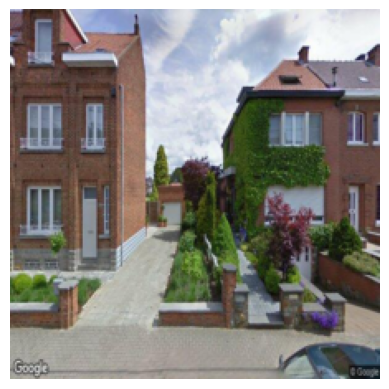

In [33]:
# Example: Visualize image tensors or labels
import matplotlib.pyplot as plt

# Display a few processed images (unnormalized for visualization)
def show_image(tensor):
    tensor = tensor.permute(1, 2, 0)  # Change dimension order to HxWxC
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # De-normalize
    tensor = torch.clip(tensor, 0, 1)  # Ensure pixel values are between 0 and 1
    plt.imshow(tensor)
    plt.axis("off")
    plt.show()

show_image(preprocessed_images[0])  # Display first image


## Split Data
- Divide your dataset into training, validation, and test sets (e.g., 70% training, 20% validation, 10% test).
- Ensure the split is random but balanced across regions or coordinate ranges.

In [35]:
from sklearn.model_selection import train_test_split

# Example split (modify if you have labels)
train_images, val_images = train_test_split(preprocessed_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(val_images, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 20137
Validation set size: 2517
Test set size: 2518


## Custom Dataset Class

In [37]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Ensure image_paths[idx] is a valid path
        image_path = self.image_paths[idx]

        # Open the image
        image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image


## Data Augmentation and Transformation for Training and Validation

In [1]:
from torchvision import transforms

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation for training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Loading Dataset using ImageFolder

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Define your dataset (replace with your own data path)
train_dataset = datasets.ImageFolder(root='/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image', transform=val_test_transform)

# Define DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


## DataLoader Setup

In [7]:
from torch.utils.data import DataLoader

batch_size = 64  # Adjust based on your GPU/CPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Model Definition with Pre-trained ResNet18

In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18 with updated weights parameter
weights = ResNet18_Weights.IMAGENET1K_V1  # Equivalent to the old 'pretrained=True'
model = resnet18(weights=weights)

# Replace the final fully connected layer for regression (output 2 values for latitude and longitude)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 outputs for lat/lon

# Now the model is ready for regression (latitude and longitude prediction)


## Model Training Loop | Regression Model

In [39]:
import os

image_directory = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image'
image_filenames = [f for f in os.listdir(image_directory) if f.endswith(('.jpeg', '.jpg'))]
print(f"Total images found: {len(image_filenames)}")


Total images found: 25172


In [51]:
import pandas as pd

coordinates_file = 'image_coordinates.csv'  # Replace with the correct CSV file path
coordinates_df = pd.read_csv(coordinates_file)
print(f"Total coordinates found: {len(coordinates_df)}")


Total coordinates found: 25001


In [3]:
import os
import pandas as pd

# Path to the images folder
images_folder = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image'
coordinates_file = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/combined_coordinates.csv'

# Read the coordinates file (assuming it has a list of latitudes and longitudes)
with open(coordinates_file, 'r') as f:
    coordinates = [line.strip().split(',') for line in f.readlines()]

# List all image filenames in the images folder
image_filenames = os.listdir(images_folder)

# Create a list of tuples (image_filename, latitude, longitude)
data = []
coordinate_index = 0
for image_filename in image_filenames:
    if image_filename.endswith('.jpg') or image_filename.endswith('.jpeg'):
        # Check if there is a corresponding coordinate
        if coordinate_index < len(coordinates):
            lat, lon = coordinates[coordinate_index]  # Get the corresponding latitude and longitude
            data.append([image_filename, lat, lon])
            coordinate_index += 1

# Convert to a DataFrame and save to CSV
df = pd.DataFrame(data, columns=['image', 'latitude', 'longitude'])
df.to_csv('image_coordinates.csv', index=False)

print("CSV file created: image_coordinates.csv")


CSV file created: image_coordinates.csv


In [5]:
# Verify consistency between CSV and image folder
csv_file = 'image_coordinates.csv'
images_folder = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image'

coordinates_frame = pd.read_csv(csv_file)
all_images = set(os.listdir(images_folder))

# Check for missing files
missing_images = coordinates_frame[~coordinates_frame['image'].isin(all_images)]
print(f"Missing images: {len(missing_images)}")
print(missing_images)

# Drop rows with missing images
coordinates_frame = coordinates_frame[coordinates_frame['image'].isin(all_images)]
print(f"Valid rows after removing missing images: {len(coordinates_frame)}")

# Save the cleaned CSV
coordinates_frame.to_csv('cleaned_image_coordinates.csv', index=False)


Missing images: 0
Empty DataFrame
Columns: [image, latitude, longitude]
Index: []
Valid rows after removing missing images: 25001


In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision import models

class StreetViewDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Read CSV and skip the header row
        self.coordinates_frame = pd.read_csv(csv_file, header=0)
        self.root_dir = root_dir
        self.transform = transform

        # Clean the data: Remove any rows where latitude or longitude are non-numeric
        self.coordinates_frame['latitude'] = pd.to_numeric(self.coordinates_frame['latitude'], errors='coerce')
        self.coordinates_frame['longitude'] = pd.to_numeric(self.coordinates_frame['longitude'], errors='coerce')

        # Remove rows where either latitude or longitude is NaN
        self.coordinates_frame.dropna(subset=['latitude', 'longitude'], inplace=True)

    def __len__(self):
        return len(self.coordinates_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.coordinates_frame.iloc[idx, 0])
        image = Image.open(img_name)

        # Ensure latitude and longitude are floats
        latitude = self.coordinates_frame.iloc[idx, 1]
        longitude = self.coordinates_frame.iloc[idx, 2]

        # Debugging: Print the raw values of latitude and longitude
        print(f"Raw latitude: {latitude}, Raw longitude: {longitude}")  # Debugging line

        # Convert latitude and longitude to float (if necessary)
        try:
            latitude = float(latitude)
            longitude = float(longitude)
        except ValueError:
            print(f"Error converting latitude/longitude to float: {latitude}, {longitude}")
            raise  # Raise the error if conversion fails

        label = [latitude, longitude]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# Model definition
class StreetViewModel(nn.Module):
    def __init__(self):
        super(StreetViewModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.resnet = models.resnet18(weights=weights)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # 2 outputs for lat/lon

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = StreetViewModel()

# Loss function and optimizer
criterion = nn.MSELoss()  # For regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataset and DataLoader setup (with num_workers=0 for debugging)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Replace with your actual CSV and image directory
csv_file = 'image_coordinates.csv'  # The CSV file you created
images_folder = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image'

# Custom dataset and dataloader
train_dataset = StreetViewDataset(csv_file=csv_file, root_dir=images_folder, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)  # Set num_workers=0 for debugging

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        images, labels = batch  # Unpack images and labels
        images = images.to(device)
        labels = labels.to(device).float()  # Ensure labels are float

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)  # MSELoss for regression
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}")


Raw latitude: 48.96825462935553, Raw longitude: 1.096246559929928
Raw latitude: 45.82181904015632, Raw longitude: 0.7670095324393857
Raw latitude: 50.55867412898522, Raw longitude: 7.605939878764165
Raw latitude: 46.19494265798456, Raw longitude: 7.844902396277979
Raw latitude: 50.809268364504504, Raw longitude: 6.645513191519001
Raw latitude: 45.095437858766005, Raw longitude: 0.8575576097498967
Raw latitude: 47.753912477838774, Raw longitude: 1.2967515292340677
Raw latitude: 42.65412376006506, Raw longitude: -1.4922030405951912
Raw latitude: 48.47735409956601, Raw longitude: -0.7305408523477954
Raw latitude: 49.975670774273006, Raw longitude: 5.388992639371857
Raw latitude: 43.938064086906195, Raw longitude: 0.5639843568739895
Raw latitude: 45.88550931573607, Raw longitude: 4.818148451098343
Raw latitude: 48.54590236466312, Raw longitude: -0.5093088197697231
Raw latitude: 45.29918039161136, Raw longitude: -0.923633346463444
Raw latitude: 46.664849846765485, Raw longitude: 5.028601034

## Freezing Pre-trained Layers

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Define the model class
class StreetViewModel(nn.Module):
    def __init__(self):
        super(StreetViewModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.resnet = models.resnet18(weights=weights)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # 2 outputs for lat/lon

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = StreetViewModel()

# Step 1: Freeze earlier layers and fine-tune the FC layer
for param in model.parameters():
    param.requires_grad = False  # Freeze earlier layers

# Unfreeze the classifier layer (self.resnet.fc)
for param in model.resnet.fc.parameters():
    param.requires_grad = True  # Unfreeze the classifier layer

# Use Adam optimizer for the fine-tuned FC layer
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=1e-4)  # Start with a higher LR for FC

# Step 2: Gradually unfreeze layers after initial training
# Example: Unfreeze the last ResNet block (self.resnet.layer4)
for param in model.resnet.layer4.parameters():
    param.requires_grad = True

# Update optimizer to include both the FC layer and the unfreezed layer4
optimizer = torch.optim.Adam([
    {'params': model.resnet.fc.parameters(), 'lr': 1e-4},  # Higher LR for FC
    {'params': model.resnet.layer4.parameters(), 'lr': 1e-5}  # Lower LR for layer4
])

# Print model summary (optional)
print(model)


StreetViewModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Training Loop with Gradients

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader  # Import Dataset here
from torchvision import transforms, models
import torch.optim as optim
import os
from PIL import Image
import pandas as pd

# Ensure the dataset class is defined
class StreetViewDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.coordinates_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.coordinates_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.coordinates_frame.iloc[idx, 0])
        image = Image.open(img_name)
        
        # Ensure latitude and longitude are floats
        latitude = self.coordinates_frame.iloc[idx, 1]
        longitude = self.coordinates_frame.iloc[idx, 2]
        
        # Debugging: Print the raw values of latitude and longitude
        print(f"Raw latitude: {latitude}, Raw longitude: {longitude}")  # Debugging line

        # Convert latitude and longitude to float (if necessary)
        try:
            latitude = float(latitude)
            longitude = float(longitude)
        except ValueError:
            print(f"Error converting latitude/longitude to float: {latitude}, {longitude}")
            raise  # Raise the error if conversion fails

        label = [latitude, longitude]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define the model class
class StreetViewModel(nn.Module):
    def __init__(self):
        super(StreetViewModel, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.resnet = models.resnet18(weights=weights)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # 2 outputs for lat/lon

    def forward(self, x):
        return self.resnet(x)

# Set the device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = StreetViewModel()
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam([
    {'params': model.resnet.fc.parameters(), 'lr': 1e-4},  # Higher LR for FC
    {'params': model.resnet.layer4.parameters(), 'lr': 1e-5}  # Lower LR for layer4
])

# Dataset and DataLoader setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Replace with your actual CSV and image directory
csv_file = 'image_coordinates.csv'  # The CSV file you created
images_folder = '/Users/mbouch17/Desktop/Personal_Data_Project/PinpointAI/jpeg_streetview_image'  # Replace with the correct path

# Custom dataset and dataloader
train_dataset = StreetViewDataset(csv_file=csv_file, root_dir=images_folder, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)  # Set num_workers=0 for debugging

# Training loop
num_epochs = 10  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for batch in train_loader:
        images, labels = batch  # Unpack images and labels
        images = images.to(device)
        labels = labels.to(device).float()  # Ensure labels are float

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)  # MSELoss for regression
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update the weights

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")


Raw latitude: 49.46645678793779, Raw longitude: 4.117136368691629
Raw latitude: 48.35925292952036, Raw longitude: 5.513574208107032
Raw latitude: 43.83381746634159, Raw longitude: -0.1767267454671603
Raw latitude: 51.01530480357064, Raw longitude: 4.574965065535816
Raw latitude: 45.47295532976404, Raw longitude: -0.3810280099313141
Raw latitude: 48.088044190203526, Raw longitude: -1.8147783597198297
Raw latitude: 49.9337502421171, Raw longitude: 5.598460577289799
Raw latitude: 45.591302631147514, Raw longitude: 4.572858667172621
Raw latitude: 45.37053073869029, Raw longitude: -0.2141330810759703
Raw latitude: 50.96965861465178, Raw longitude: -1.385121724537362
Raw latitude: 50.1181092874927, Raw longitude: 2.9244107546815963
Raw latitude: 47.64562119139146, Raw longitude: 3.4364595575818377
Raw latitude: 47.143746304308046, Raw longitude: -2.0213628041011327
Raw latitude: 46.6615478454182, Raw longitude: 4.87918934186513
Raw latitude: 48.099306493762086, Raw longitude: 7.1148714489818

ValueError: could not convert string to float: 'Latitude'

## Validation Loop

In [53]:
with torch.no_grad():
    model.eval()
    val_loss = 0.0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

Validation Loss: 3.9286


## Test the Model

In [55]:
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Loss: 3.9286
Test Accuracy: 0.00%


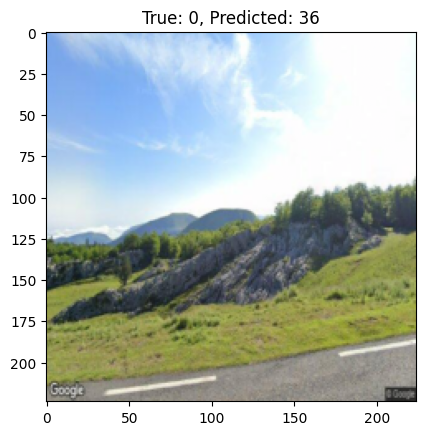

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize the image
def denormalize_image(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    tensor = tensor * std + mean  # Reverse the normalization
    return tensor

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Denormalize the image for visualization
        denormalized_image = denormalize_image(images[0], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        denormalized_image = denormalized_image.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

        # Clip values to be in range [0, 1]
        denormalized_image = np.clip(denormalized_image, 0, 1)

        # Display the image
        plt.imshow(denormalized_image)
        plt.title(f"True: {labels[0].item()}, Predicted: {predicted[0].item()}")
        plt.show()
        break  # Display just one image


## Save & Deploy Model

In [58]:
#Save the model
torch.save(model.state_dict(), "fine_tuned_model.pth")


In [59]:
model.load_state_dict(torch.load("fine_tuned_model.pth", weights_only=True))


<All keys matched successfully>